<a href="https://colab.research.google.com/github/Sim-mi-gyeong/DeepLearning/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

In [ ]:
pip install -q tensorflow-gpu==2.0.0-rc1

     |████████████████████████████████| 380.5MB 41kB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
     |████████████████████████████████| 4.3MB 24.1MB/s 
     |████████████████████████████████| 501kB 60.2MB/s 


In [ ]:
tf.__version__

'2.5.0'

In [ ]:
pip install -q imageio

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
from tensorflow.keras import layers

from IPython import display

In [ ]:
(train_images, train_labels), (_ , _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
train_images = (train_images-127.5)/127.5

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256  
# batch_size: 몇 개의 샘플로 가중치를 갱신할 것인지 설정
# 배치사이즈가 클수록 많은 데이터를 저장해두어야 하므로 용량이 커야함
# 배치사이즈가 작으면 학습은 촘촘하게 되지만 계속 레이블과 비교하고, 가중치를 업데이트하는 과정을 거치며 시간이 오래 걸림

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# tf.data.Dataset 를 생성하는 함수로 입력된 텐서로부터 slices를 생성
# batch(): 데이터를 읽어올 개수를 지정

In [ ]:
# 생성자
# 시드값 -> 이미지 생성 : 업샘플링층(tf.keras.layers.Conv2DTranspose) -> 28x28x1 이미지
# 각 층마다 활성함수: LeakyReLU / 마지막 층: tanh

In [ ]:
def make_generator_model():  # Generator의 input 공간인 latent space(vector): 산술 특성, 생성된 이미지의 특성 조작 가능
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) 
  # 출력으로 28*28 grey scale의 이미지를 필요로 -> grey scale은 필터 수 1 -> Conv2DTranspose(None, 14,14,x) -> output: (None, 28,28,1)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7,7,256)))
  assert model.output_shape==(None,7,7,256) # 배치사이즈로 None

  model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding="same", use_bias=False))
  assert model.output_shape == (None,7,7,128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model

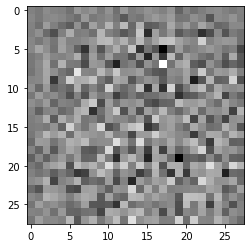

In [ ]:
# 훈련되지 않은 생성자를 이용해 이미지 생성

generator = make_generator_model()

noise = tf.random.normal([1,100]) # 정규분포 난수 생성 (1행 100열)
generated_images = generator(noise, training=False)

plt.imshow(generated_images[0, : , : , 0], cmap='gray')

In [ ]:
# 감별자: 합성곱 신경망 기반의 이미지 분류기

def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[ 28, 28, 1]))

  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [ ]:
# 아직 훈련되지 않은 감별자를 사용해 생성된 이미지의 진짜/가짜 여부 판별
# 모델은 진짜 이미지: 양수(positive)의 값, 가짜 이미지: 음수(negative)의 값 출력

discriminator = make_discriminator_model()
decision = discriminator(generated_images)

print(decision)

tf.Tensor([[0.00013294]], shape=(1, 1), dtype=float32)


In [ ]:
# 손실함수와 옵티마이저 정의
# cross entropy loss를 계산하기 위해 헬퍼(helper) 함수 반환
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) 

# logit: 모델의 출력값이 문제에 맞게 normalize 되었느냐의 여부
# 클래스 분류 문제에서 softmax 함수를 거치면 from_logits = False(default값), 그렇지 않으면 from_logits = True

In [ ]:
# 감별자 손실함수
# 해당 메서드는 감별자가 가짜 이미지에서 얼마나 진짜 이미지를 잘 판별하는지를 수치화
# 진짜 이미지에 대한 감별자의 예측과 1로 이루어진 행렬 비교
# 가짜(생성된) 이미지에 대한 감별자의 예측과 0으로 이루어진 행렬 비교

In [ ]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [ ]:
# 생성자 손실함수
# 감별자를 얼마나 잘 속였는지 수치화
# 생성자가 원활히 수행 -> 감별자가 가짜 이미지를 진짜(1)로 분류
# 생성된 이미지에 대한 감별자의 결정을 1로 이루어진 행렬과 비교

In [ ]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
# 감별자와 생성자: 따로 훈련 -> 옵티마이저 다름

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# 체크포인트 저장

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 dsicriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [ ]:
# 훈련 루프 정의

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# 훈련 루프는 생성자가 입력으로 랜덤 시드를 받는 것으로부터 시작 -> 시드값을 사용해 이미지 생성
# 감별자 사용해 (훈련 세트에서 가져온) 진짜 이미지와 (생성자가 생성해낸) 가짜 이미지 분류
# 각 모델의 손실 계산, 그래디언트 사용해 생성자와 감별자 업데이트

In [ ]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim]) # BATCH_SIZE: 256

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: # tf.GradientTape(): 미분 계산 값을 기록하는 객체
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
from IPython.display import clear_output

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # GIF를 위한 이미지를 바로 생성
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # 15 epoch가 지날 때마다 모델 저장
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
    print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))

    # 마지막 에포크가 끝난 후 생성
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [ ]:
# 이미지 생성 및 저장

def generate_and_save_images(model, epoch, test_input):
     # `training`이 False로 -> (배치 정규화를 포함한) 모든 층들이 추론 모드로 실행
     predictions = model(test_input, training=False)

     fig = plt.figure(figsize=(4,4))

     for i in range(predictions.shape[0]):
       plt.subplot(4,4,i+1)
       plt.imshow(predictions[i, :, :, 0]* 127.5 +127.5, cmap='gray')
       plt.axis('off')
     
     plt.savefig('image_at_epoch{:04d}.png'.format(epoch))
     plt.show()

In [ ]:
from IPython.display import clear_output

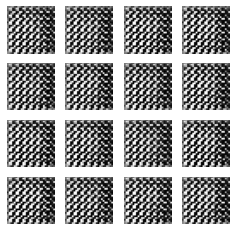

In [ ]:
# 모델 훈련
# train() 메서드를 생성자와 감별자를 동시에 훈련하기 위해 호출 - 서로 제압 X

%%time
train(train_dataset, EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)

In [ ]:
# 마지막 체크포인트를 복구
checkpoint_restore(tf.train_latest_checkpoint(checkpoint_dir))

In [ ]:
# GIF 생성

def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCH)

In [ ]:
# imageio로 훈련 중에 저장된 이미지를 사용해 GIF 애니메이션 만들기

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)